In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial


def finetune(x, grad_fn, outer_lr=0.001, **kwargs):
    grad = grad_fn(x)
    return x - outer_lr * grad

def reptile(x, grad_fn, T=10, epsilon=1, inner_lr=0.01, display=False, **kwargs):
    init = x
    xc = x
    for t in range(T):
        grad = grad_fn(xc)
        xc -= inner_lr * grad
    if display:
        plt.plot([xc]*100,np.linspace(0,17500,100),'--',color='green')
        print("here now:", xc)
    return init + epsilon*(xc - init)

def maml(x, grad_fn, T=10, outer_lr=0.001, inner_lr=0.01, display=False, **kwargs):
    init = x
    xc = x
    for t in range(T):
        grad = grad_fn(xc)
        xc -= inner_lr * grad
    grad = grad_fn(xc)
    if display:
        plt.plot([xc]*100,np.linspace(0,17500,100),'--',color='green')
        print("here now:", xc, "grad:", grad)

    return init - outer_lr * grad

## Scenario 2

### The task loss landscape

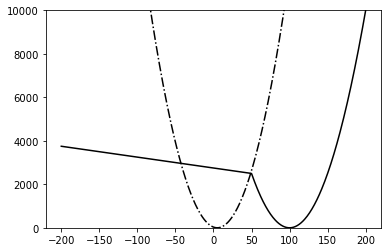

In [4]:
def fun(x, c=1, t=0, leftbound=None, c2=2):
    if leftbound is None: return c*(x-t)**2
    # Indices of answer outputs that will be bounded
    lids = x <= (t - leftbound)
    bound = c*(t-leftbound-t)**2
    
    ans = c*(x-t)**2
    ans[lids] = c2*(t - leftbound - x[lids]) + bound 
    #ans[lids] = ans[lids] * bound
    return ans

def gfn1(x, c, t):
    return 2*c*(x-t)

def gfn2(x, c, t, leftbound=None, c2=2):
    if leftbound is None:
        return gfn1(x,c,t)
    if x > t - leftbound:
        return gfn1(x,c,t)
    return -c2
    
    
t1_params = {'c': 1.3,'t': 5}
t2_params = {'c':1, 't':100, 'leftbound':50, 'c2':5}

x = np.linspace(-200,+200, 500)
task1 = partial(fun, **t1_params)
task2 = partial(fun, **t2_params)
grad_fn1 = partial(gfn1, **t1_params)
grad_fn2 = partial(gfn2, **t2_params)

plt.ylim((0,10000))
plt.plot(x,task1(x),'-.',color='black', label='Task 1')
plt.plot(x,task2(x),color='black', label='Task 2')

### Solutions found by Finetuning, MAML, Reptile

Figure for T=5


c:\users\intel\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


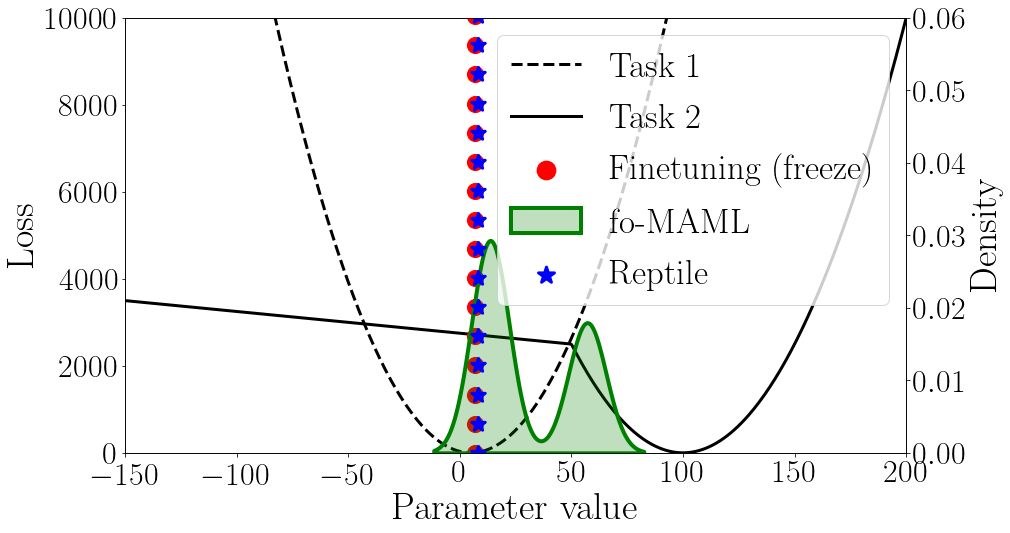

Figure for T=25


c:\users\intel\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


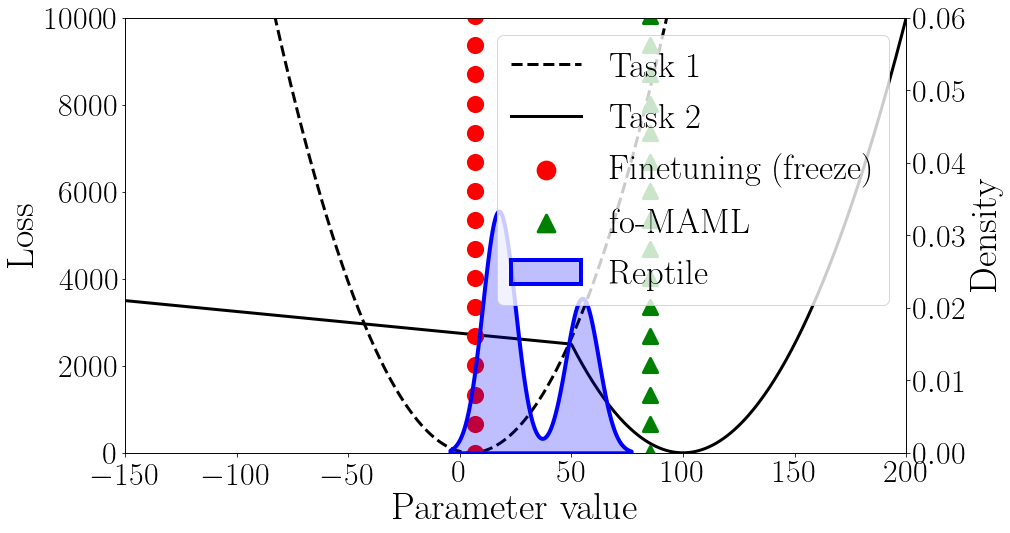

In [5]:
import scipy.stats as stats
from matplotlib import rc
import matplotlib.pylab as plt
import seaborn as sns

for T in [5, 25]:
    print(f"Figure for T={T}")
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    plt.ylim((0,10000))
    plt.xlim((-150,200))
    ax.plot(x,task1(x),'--',color='black', label='Task 1', linewidth=3)
    ax.plot(x,task2(x),color='black', label='Task 2', linewidth=3)

    np.random.seed(1337)

    algorithms = [finetune,  maml, reptile]
    converged = []
    labels = ["Finetuning (freeze)", "fo-MAML", "Reptile"]
    colors = ['red', 'green', 'blue']
    markers = ['o','^','*']

    tasks = [task1, task2]
    grad_fns = [grad_fn1, grad_fn2]
    params={'outer_lr':0.1, 'inner_lr':0.1, 'T':T, 'epsilon':0.1}
    tid = 0

    init_vals = np.linspace(-200, 200, 100)
    for epoch in init_vals:
        inits = [epoch]*3 #np.random.uniform(-200, 200, 3)
        for step in range(15000):
            for aid, algorithm in enumerate(algorithms):
                inits[aid] = algorithm(inits[aid], grad_fns[tid], **params)
            tid = -1*tid + 1 # flip task switch
        converged.append(inits)
    plt.ylabel("Loss", fontsize=38)
    plt.yticks(fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlabel("Parameter value", fontsize=38)
    ax2 = plt.twinx()
    ax2.set_ylim((0,0.06))

    for i, label in enumerate(labels):
        mu = np.mean([x[i] for x in converged])
        sigma = np.std([x[i] for x in converged])
        plotx = np.linspace(-150, 200, 1000)
        if sigma < 1:
            ax2.scatter([mu]*250, np.linspace(0,1,250), linewidth=3, color=colors[i], marker=markers[i],s=200, label=label)
        else:
            sns.distplot(np.array([x[i] for x in converged]), kde=True, kde_kws={"linewidth":4, "fill":True}, color=colors[i], hist=False, label=label, ax=ax2)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lgnd = ax2.legend(lines + lines2, labels + labels2, fontsize=35, markerscale=3)
    for handle in lgnd.legendHandles:
        try:
            handle.set_sizes([280.0])
        except:
            pass

    plt.ylabel("Density", fontsize=38)
    plt.yticks(fontsize=32)
    #plt.legend(fontsize=35, markerscale=3)
    plt.xticks(fontsize=32)
    plt.savefig(f"tfmeta_plotT{params['T']}.pdf")
    plt.show()

## Scenario 1


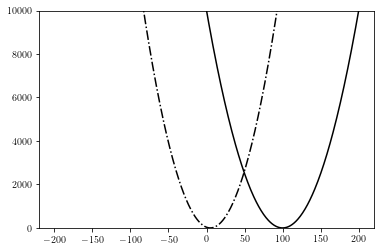

In [6]:
t1_params = {'c': 1.3,'t': 5}
t2_params = {'c':1, 't':100}

task1 = partial(fun, **t1_params)
task2 = partial(fun, **t2_params)
grad_fn1 = partial(gfn1, **t1_params)
grad_fn2 = partial(gfn2, **t2_params)

plt.ylim((0,10000))
plt.plot(x,task1(x),'-.',color='black', label='Task 1')
plt.plot(x,task2(x),color='black', label='Task 2')

Plot for T=5


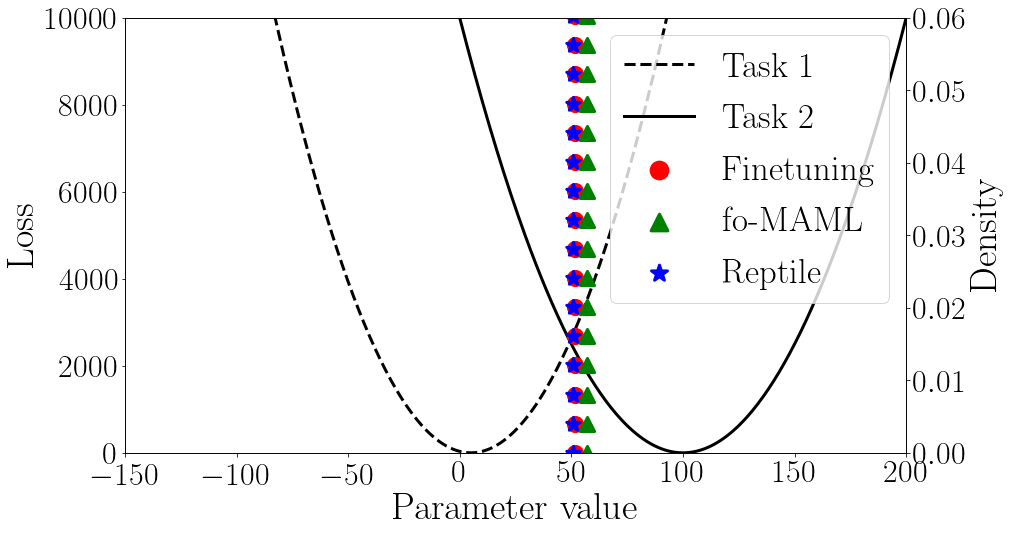

Plot for T=25


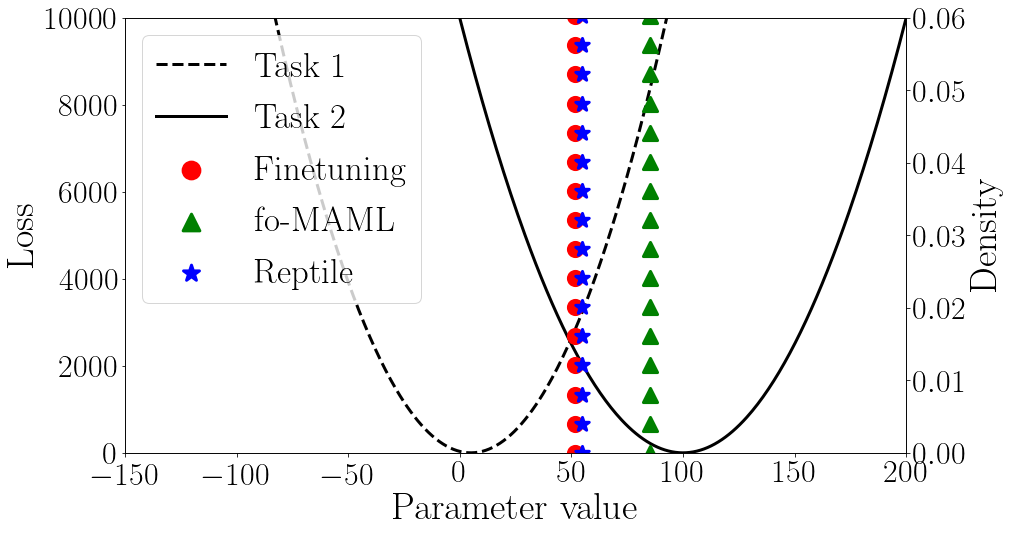

In [7]:
import scipy.stats as stats
from matplotlib import rc
import matplotlib.pylab as plt
import seaborn as sns


for T in [5, 25]:
    print(f"Plot for T={T}")
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    plt.ylim((0,10000))
    plt.xlim((-150,200))
    ax.plot(x,task1(x),'--',color='black', label='Task 1', linewidth=3)
    ax.plot(x,task2(x),color='black', label='Task 2', linewidth=3)

    np.random.seed(1337)

    algorithms = [finetune, maml, reptile]
    converged = []
    labels = ["Finetuning", "fo-MAML", "Reptile"]
    colors = ['red', 'green', 'blue']
    markers = ['o','^','*']

    tasks = [task1, task2]
    grad_fns = [grad_fn1, grad_fn2]
    params={'outer_lr':0.1, 'inner_lr':0.1, 'T':T, 'epsilon':0.1}
    tid = 0

    init_vals = np.linspace(-200, 200, 100)
    for epoch in init_vals:
        inits = [epoch]*3 #np.random.uniform(-200, 200, 3)
        for step in range(15000):
            for aid, algorithm in enumerate(algorithms):
                inits[aid] = algorithm(inits[aid], grad_fns[tid], **params)
            tid = -1*tid + 1 # flip task switch
        converged.append(inits)
    plt.ylabel("Loss", fontsize=38)
    plt.yticks(fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlabel("Parameter value", fontsize=38)
    ax2 = plt.twinx()
    ax2.set_ylim((0,0.06))

    for i, label in enumerate(labels):
        mu = np.mean([x[i] for x in converged])
        sigma = np.std([x[i] for x in converged])
        plotx = np.linspace(-150, 200, 1000)
        if sigma < 1:
            ax2.scatter([mu]*250, np.linspace(0,1,250), linewidth=3, color=colors[i], marker=markers[i],s=200, label=label)
        else:
            sns.distplot(np.array([x[i] for x in converged]), kde=True, kde_kws={"linewidth":4, "fill":True}, color=colors[i], hist=False, label=label, ax=ax2)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lgnd = ax2.legend(lines + lines2, labels + labels2, fontsize=35, markerscale=3)
    for handle in lgnd.legendHandles:
        try:
            handle.set_sizes([280.0])
        except:
            pass
    plt.ylabel("Density", fontsize=38)
    plt.yticks(fontsize=32)
    #plt.legend(fontsize=35, markerscale=3)
    plt.xticks(fontsize=32)
    plt.savefig(f"tfmeta_sameT{params['T']}.pdf")
    plt.show()